<a href="https://colab.research.google.com/github/KaraNoSora/SE207_WI22_Course_Materials/blob/main/Project/SE_207_Final_Project_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SE 207 Final Project (Winter 2022)

---

**Due**: March 18, 11:59 pm


## **Problem 2** : Deep learning based Homogenization Approach for Composite Material

---

**Background:** A composite material is often difficult to model since it consists of various components exhibiting multiple mechanical properties. High fidelity modeling requires an extremely fine mesh to include all the grains and matrices of the composite material. To reduce computational cost, we use a Representative Volume Element (RVE) to condense these material properties. In particular, a recurrent material piece in the microscopic view will be simplified to a material point with some estimated overall material properties in the macroscopic view. This so-called homogenization technique leads to a fictitious homogeneous material that is easy to model. With the development of deep learning, homogenization via deep networks has become a popular research topic.






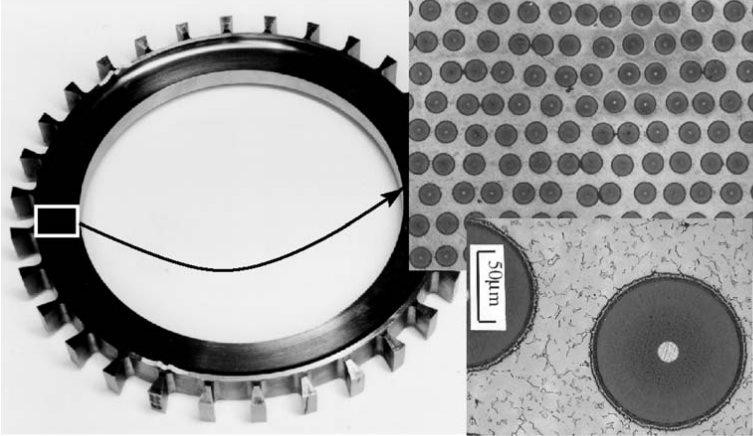

The SiC-Ti ring above is composed of two materials. Its microsturcture is shown on the right. If we want to model the ring with only one material, the microstructure has to be homogenized.

Figure source: Kanouté, Pascale, et al. "Multiscale methods for composites: a review." Archives of Computational Methods in Engineering 16.1 (2009): 31-75.

**Part 1**

In this problem, you are given a dataset of 2000 synthetic $128\times 128$ images (see an example below) as RVEs, along with their overall (homogenized) material properties such as Young's modulus, Poisson's ratio. The dataset includes 2 columns for the overall Young's moduli and Poisson's ratios. Each RVE contains only two materials. The properties of the "black" and "white" materials are

* $E_0 = 2.5\times 10^{6}, \nu_0 = 0.15$
* $E_1 = 3\times 10^{9}, \nu_1 = 0.3$



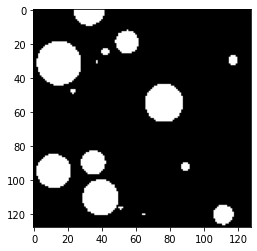

These two material properties do not change for the RVEs. 

1. Train a Convolutional Neural Network to fit the RVE images and the properties of homogenized materials (given RVE image as input, the model predicts the homogenized properties as output). We can start with such an architecture:

\begin{matrix}
    {\rm Conv\ layer: 5\times 5\ filter,\ 8\ out\ channels}\\
    {\rm ReLU}\\
    {\rm Average\ pooling: stride\ 3}\\
    {\rm Conv\ layer: 5\times 5\ filter,\ 16\ out\ channels}\\
    {\rm ReLU}\\
    {\rm Average\ pooling: stride\ 6}\\
    {\rm Flatten\ all\ feature\ maps}\\
    {\rm FC\ layer\ 1}\\
    {\rm ReLU}\\
    {\rm FC\ layer\ 2\\}
\end{matrix}

2. You may find that the data are insufficient, and overfitting occurs. Try to augment this dataset and train the network again. For example, you can flip or rotate the RVE images.

3. Discuss your results in 1. and 2.

In [1]:
#@title import libraries
import time
import torch
import torch.nn as nn
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import shutil
import matplotlib as ml
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from joblib import dump, load
from sklearn.metrics import mean_squared_error
global device, print_freq
device = torch.device('cuda')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

ml.rc('font', **font)
plt.rc('text', usetex=True)
from numpy import genfromtxt

## Problem 1(a) - Using the original data

In [2]:
# ####################### Original dataset ###########################

# imgs         = np.load('rve_image_p1.npy')
# properties   = np.load('overall_property_p1.npy')


# properties.astype(np.float32)
# imgs.astype(np.float32)

# rng = np.random.default_rng()
# numbers = rng.choice(2000, size=2000, replace=False)
# imgs = imgs[numbers].copy()
# properties = properties[numbers,0:2].copy()

# imgs = np.reshape(imgs, (2000, 1, 128, 128))
# imgs_tensor = torch.from_numpy(imgs)

# E_transform  = MinMaxScaler()
# nu_transform = MinMaxScaler()
# original_E   = properties[:,0:1].copy()
# original_nu  = properties[:,1:2].copy()
# E  = E_transform.fit_transform(properties[:,0:1])
# nu = nu_transform.fit_transform(properties[:,1:2])
# properties_tensor = torch.zeros(2000, 2)
# properties_tensor[:,:] = torch.from_numpy(np.hstack((E, nu)))

## Problem 1(b)  - Augmenting the data by rotation and flipping

In [3]:
# ###################### Augmented original dataset (rotated and flipped) ################

imgs        = np.load('rve_image_p1.npy') 
properties  = np.load('overall_property_p1.npy')
 
imgs_rot    = np.rot90(imgs, 1, (1, 2))
imgs_trans  = np.flip(imgs, (1))
imgs_aug    = np.concatenate((imgs, imgs_rot, imgs_trans), axis=0)
imgs_aug    = np.reshape(imgs_aug, (6000, 1, 128, 128))

properties_aug              = np.zeros((6000,2))
properties_aug[0:2000,:]    = properties
properties_aug[2000:4000,:] = properties
properties_aug[4000:6000,:] = properties


#@title Shuffle images and labels

# create non-repeative integers from 0 to 19999 as the index array
rng     = np.random.default_rng()
numbers = rng.choice(6000, size=6000, replace=False)

# shuffle the images and labels
imgs_aug       = imgs_aug[numbers].copy()
properties_aug = properties_aug[numbers].copy()

idx                        = properties_aug[:,1:2] > 0.2
imgs_outlier_removed       = imgs_aug[idx[:,0],:,:,:]
properties_outlier_removed = properties_aug[idx[:,0],:]

#@title Data to tensors
imgs_outlier_removed.astype(np.float32)
imgs_tensor  = torch.from_numpy(imgs_outlier_removed)

E_transform  = MinMaxScaler()
nu_transform = MinMaxScaler()

original_E   = properties_outlier_removed[:,0:1].copy()
original_nu  = properties_outlier_removed[:,1:2].copy()

E  = E_transform.fit_transform(properties_outlier_removed[:,0:1])
nu = nu_transform.fit_transform(properties_outlier_removed[:,1:2])

# convert the label array to a tensor
E.astype(np.float32)
nu.astype(np.float32)
properties_tensor = torch.empty((E.size, 2), dtype=torch.float32)
properties_tensor[:,:] = torch.from_numpy(np.hstack((E, nu)))

In [4]:
#@title Auxiliary class: Data set
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        self.inp = inp
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.out[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
#@title train_step(), test_step()
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        loss   = criterion(output, target)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 10 == 0:

            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg

def test_step(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        loss   = criterion(output, target)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 10 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses))

    return losses.avg

In [6]:
#@title train_NN()

# early stoping: save the model with the lowest test loss
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train_NN(model, net_info, train_loader, test_loader):
    epochs       = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses  = np.empty([epochs, 1])

    min_loss = 1e4

    # In this case, we should use the binary cross-entropy as the loss function
    lossfun   = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 50:
            if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp   = train_step(train_loader, model, lossfun, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp   = test_step(test_loader, model, lossfun, epoch)
        test_losses[epoch] = test_losses_temp

        # remember the best test set performance and save checkpoint
        is_best  = test_losses[epoch] > min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('val_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    
    # plot training/test loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi = 600)
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')
    ax[0].grid('on')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Validation loss')
    ax[1].set_yscale('log')
    ax[1].grid('on')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"    
    return model

In [7]:
#@title CNN Architecture
class rveCNN(torch.nn.Module):

    def __init__(self):

        super().__init__()

        # a 8 x 1 x 5 x 5 filter
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0)
        # a 16 x 8 x 5 x 5 filter
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
       
        self.avgpool1 = torch.nn.AvgPool2d(kernel_size=3, stride=3)
        self.avgpool2 = torch.nn.AvgPool2d(kernel_size=6, stride=6)
        
        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(in_features=576, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        
        # convert x to the dtype 'torch.float32'
        out = self.conv1(x.float())
        out = self.relu(out)
        out = self.avgpool1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.avgpool2(out)

        # flatten all fature maps: reshape(out.size(0), -1) means that all dimensions
        # of 'out' collapse except for the first one (batch).
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        return out

In [8]:
A = torch.rand(1, 1, 128, 128)
test = rveCNN()
test.forward(A)

tensor([[0.1264, 0.0073]], grad_fn=<ReluBackward0>)

In [9]:
trainer_info = {'epochs':      300, 
                'train_size':  4000,
                'train_batch': 100,
                'test_batch':  200,
                'lr0':         1e-3,
                'lr_decay':    0.2}

note = 'rve_part1_test'
print_freq = 300

model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['epochs']) + 'ep_' + note
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('model name: ' + model_name)
print(device)

model name: model_4000train_300ep_rve_part1_test
cuda


In [10]:
#@title main_program
def main_program(inp, out, trainer_info, model_name):

    num_sample   = trainer_info['train_size']
    inp_train    = inp[0:num_sample, :, :, :]
    out_train    = out[0:num_sample,:]
    training_set = MyDataset(inp_train, out_train)
    inp_test     = inp[num_sample:5000, :, :, :]
    out_test     = out[num_sample:5000,:]
   
    
    test_set     = MyDataset(inp_test, out_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set, 
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    
    test_loader  = torch.utils.data.DataLoader(dataset=test_set, 
                                              batch_size=trainer_info['test_batch'], 
                                              shuffle=True)

    # train the model
    model = rveCNN().to(device)
    print(model_name)
    print(model)
    
    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), model_name)

    return model

model_4000train_300ep_rve_part1_test
rveCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (avgpool2): AvgPool2d(kernel_size=6, stride=6, padding=0)
  (relu): ReLU()
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Epoch: [0/300][0/40]	LR: 0.001	Time 0.072 (0.072)	Data 0.003 (0.003)	Loss 0.2072617 (0.207262)	
Test: [0/5]	Time 0.009 (0.009)	Loss 0.0980719 (0.0981)	
Epoch: [10/300][0/40]	LR: 0.001	Time 0.007 (0.007)	Data 0.001 (0.001)	Loss 0.0019648 (0.001965)	
Test: [0/5]	Time 0.009 (0.009)	Loss 0.0034136 (0.0034)	
Epoch: [20/300][0/40]	LR: 0.001	Time 0.007 (0.007)	Data 0.001 (0.001)	Loss 0.0030670 (0.003067)	
Test: [0/5]	Time 0.009 (0.009)	Loss 0.0037014 (0.0037)	
Epoch: [30/300][0/40]	LR: 0.001	Time 0.009 (0.009)	Data 0.002 (0.002)	Loss 0.0020182 (0.002018)	
Test: [0/5]	Time 0.0

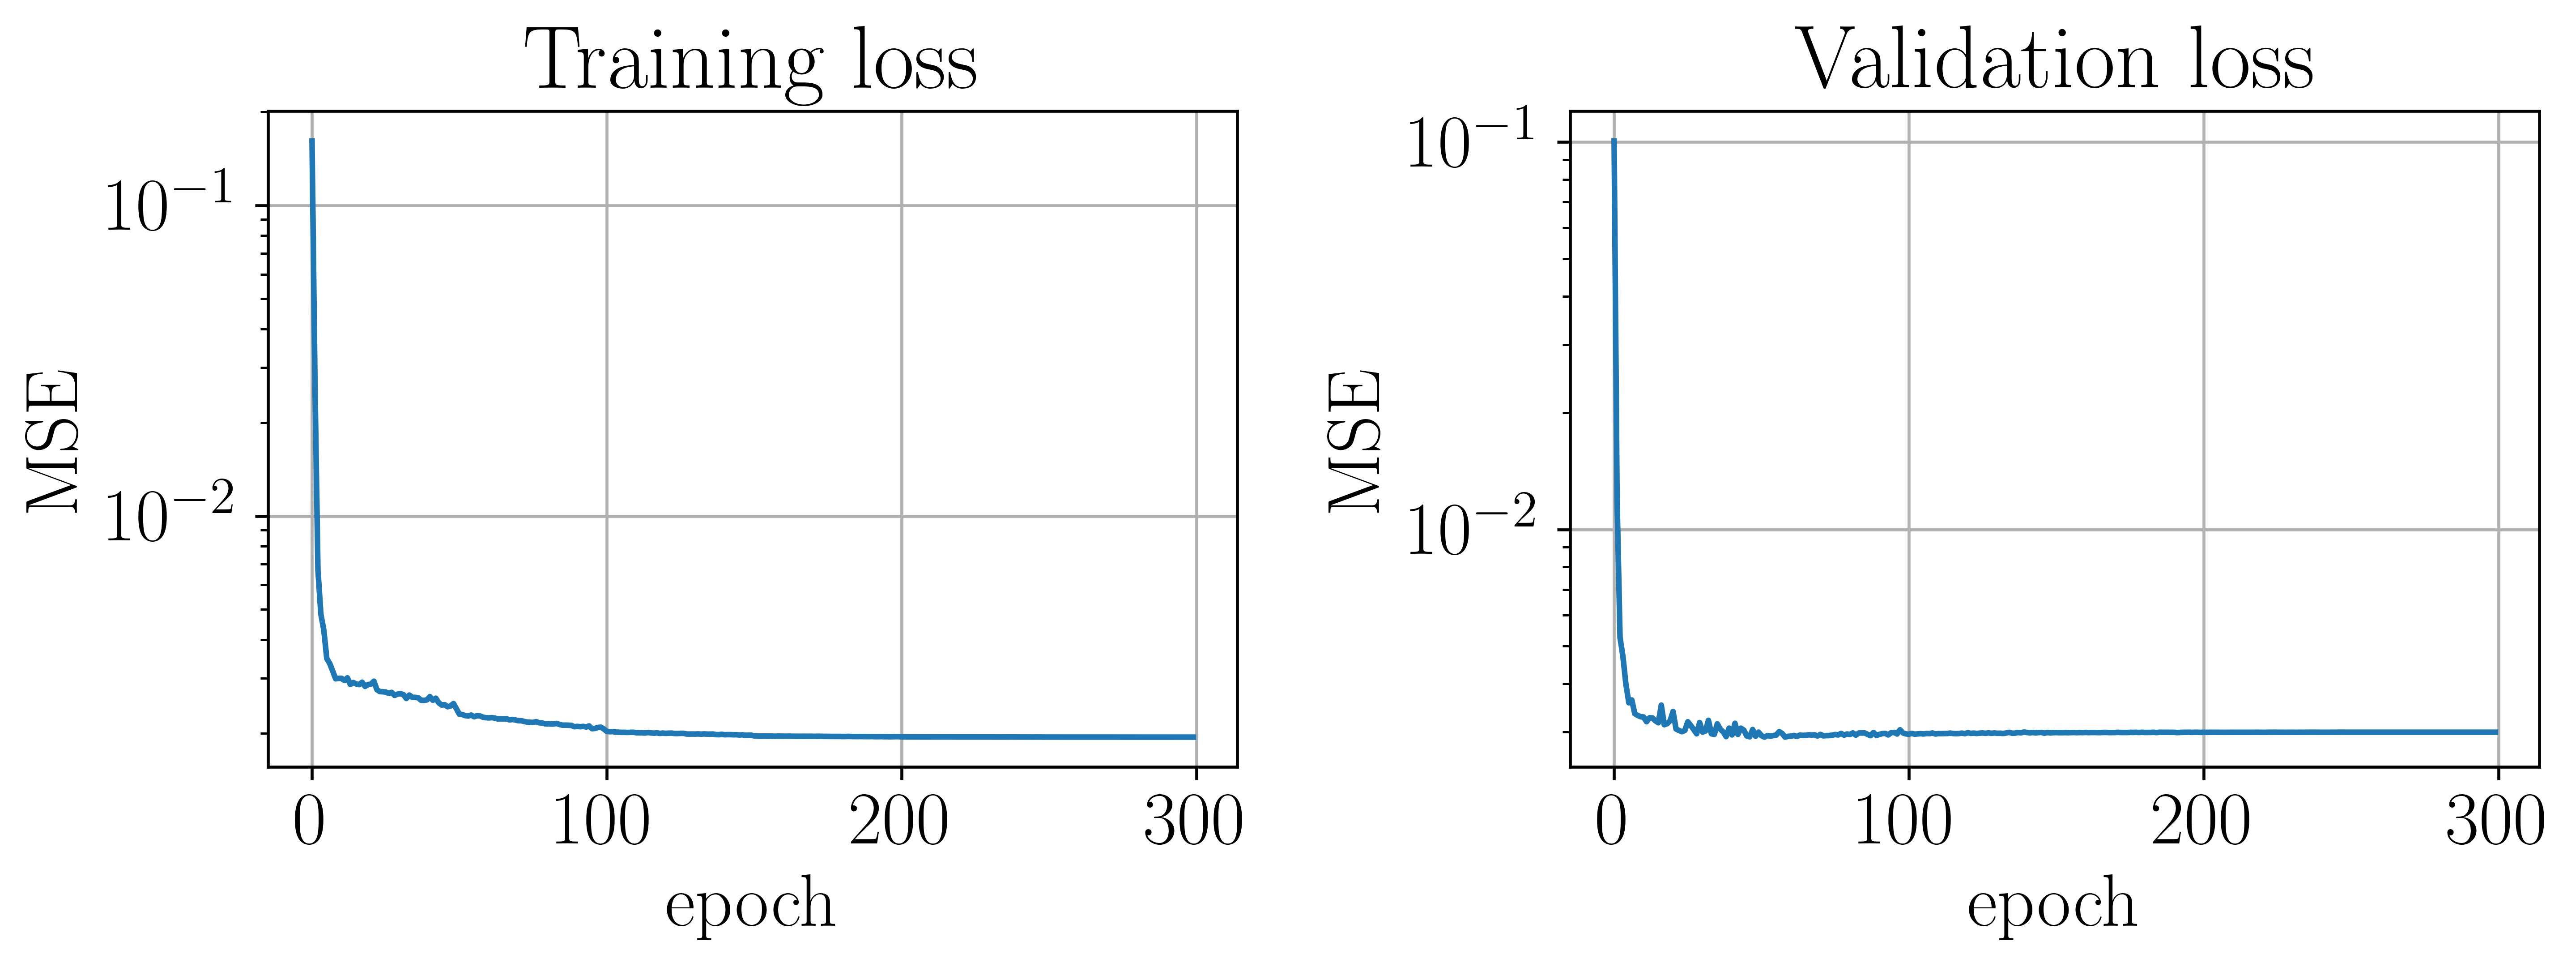

In [11]:
print_freq = 100
device     = torch.device('cuda')
model      = main_program(imgs_tensor, properties_tensor, trainer_info, model_name)

## Postprocessing of data for 1(a) and 1(b)

In [19]:
nstart = 5000
nend   = 5973

yhat       = model(imgs_tensor[nstart:nend,:,:,:].to(device))
yhat_numpy = yhat.detach().cpu().numpy()
mean_squared_error(yhat_numpy[:,1:2], nu[nstart:nend,0:1])
print(mean_squared_error(yhat_numpy[:,0:1], E[nstart:nend,0:1]))
print(mean_squared_error(yhat_numpy[:,1:2], nu[nstart:nend,0:1]))
print(mean_squared_error(yhat_numpy, np.hstack((E[nstart:nend], nu[nstart:nend]))))

0.0003689253797531611
0.004409186484625664
0.0023890559321894144


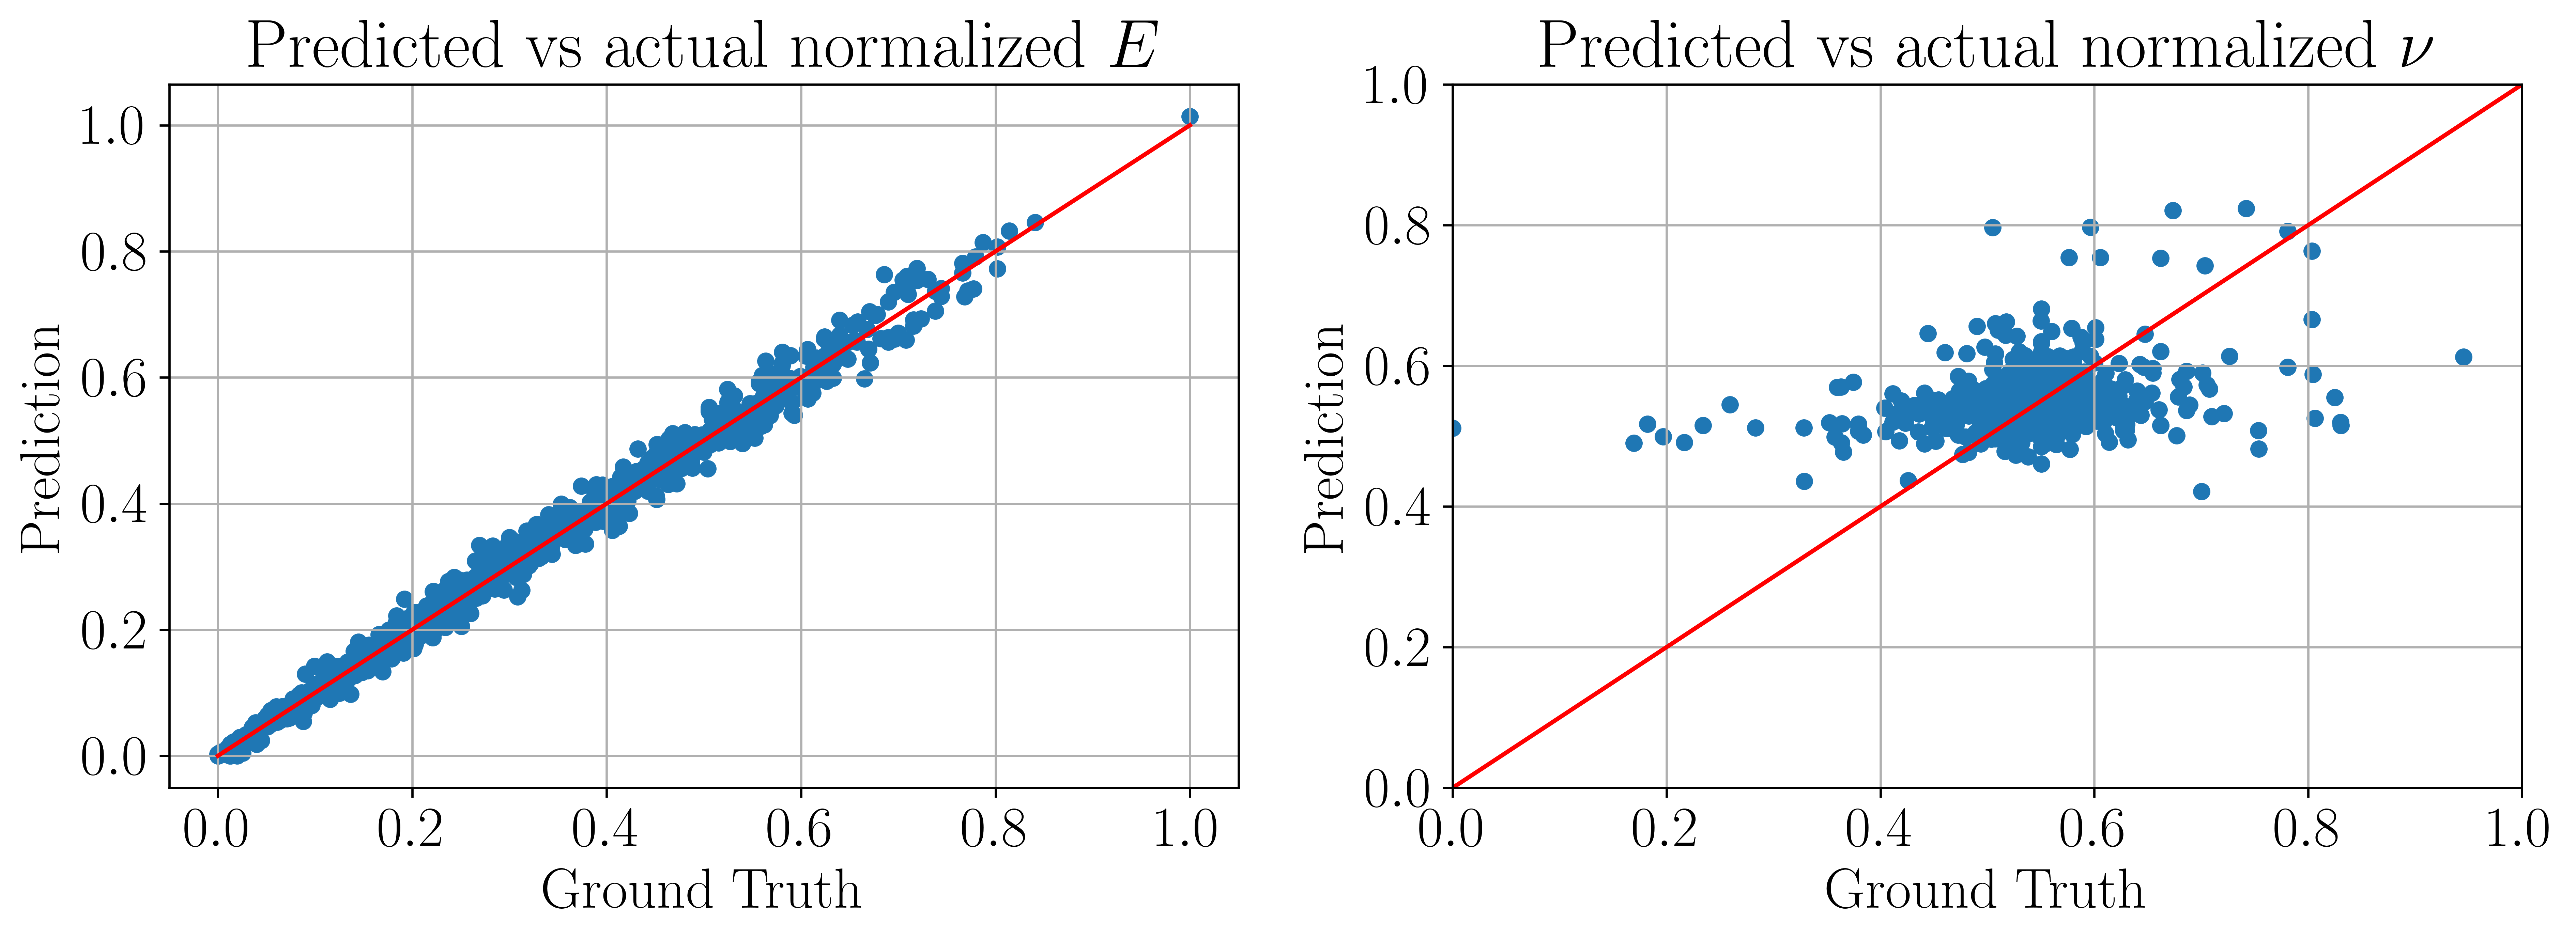

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi = 600)
ax[0].scatter(E[nstart:nend], yhat_numpy[:,0:1], linewidths=0.1)
ax[0].plot([0, 1], [0, 1], color='red')
ax[0].title.set_text('Predicted  vs actual normalized $E$')
ax[0].set_xlabel('Ground Truth')
ax[0].set_ylabel('Prediction')
ax[0].grid('on')

ax[1].scatter(nu[nstart:nend], yhat_numpy[:,1:2], linewidths=0.1)
ax[1].plot([0, 1], [0, 1], color='red')
ax[1].title.set_text(r'Predicted vs actual normalized $\nu$')
ax[1].set_xlabel(' Ground Truth')
ax[1].set_ylabel('Prediction')
ax[1].grid('on')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"    

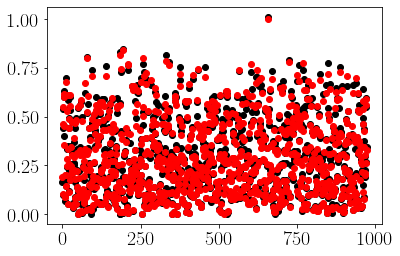

In [27]:
plt.plot(yhat_numpy[:,0:1],'ko')
plt.plot(E[nstart:nend],'ro')
plt.show()

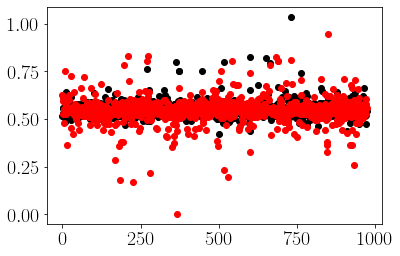

In [26]:
plt.plot(yhat_numpy[:,1:2],'ko')
plt.plot(nu[nstart:nend],'ro')

plt.show()